# Entrega 2 - Predictor de muerte de pacientes con HIV utilizando Naive Bayes

### Grupo 26:
     - Agustín Martínez  C.I 5.074.743-0
     - Joaquín Mezquita  C.I 5.239.865-9
     - Nicolás Núñez     C.I 5.127.722-0

## 1. Objetivo

El objetivo principal de esta tarea es construir un algoritmo capaz de predecir la muerte de pacientes bajo observación por HIV utilizando metodos bayesianos, croncretamente el algoritmo de Naive Bayes visto en el curso. Para ello, utilizaremos el dataset `AIDS Clinical Trials Group Study 175` tomando como valor a predecir el indicador de censura `cid`.

El indicador de censura puede tomar dos valores "censoring" o "failure". La censura ocurre cuando un valor de una observación solo se conoce parcialmente. 

En este caso ocurre cuando el experimento termina en un momento determinado, tras el cuál los pacientes todavía vivos quedan todos censurados por la derecha.  

Luego del momento de la última observación no se conocen datos sobre la muerte o supervivencia de los pacientes. Por lo que se puede tomar únicamente el caso "failure" como la muerte de un paciente.


In [ ]:
import funciones
import pandas as pd
import numpy as np
import sklearn.preprocessing as sk_pre
from sklearn.model_selection import train_test_split
from sklearn.metrics import  accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import KFold
from scipy.stats import chi2_contingency
from sklearn.preprocessing import KBinsDiscretizer
from sklearn import metrics
import scipy.stats
import importlib
from sklearn.feature_selection import chi2

importlib.reload(funciones)

# Objetivo a predecir
OBJETIVO = 'cid'

dataset = pd.read_csv('data.csv')

## 2. Diseño del predictor

 ### 2.1 Partición del conjunto de datos y evaluación

Para realizar el entrenamiento, ajuste de la solución y evaluación del modelo, el dataset es separado en 2 conjuntos:

- Entrenamiento (85%): Utilizado para entrenar el algoritmo de Naive Bayes
- Evaluación (15%): Para obtener métricas de rendimiento del modelo una vez finalizado.

Además, para ajustar los hiperparametros del modelo, utilizaremos `validación cruzada`, dividiendo el conjunto de  entrenamiento en 5 partes iguales. Es por esto que no se utiliza una partición de validación.

Pot último, a la hora de separarlos, utilizamos estratificación de forma que la distribución de la columna `cid` sea similar en X_train, X_test, y las particiones a la hora de efectuar validación cruzada.

Al momento de evaluar las soluciones se utilizan las siguientes métricas, calculadas con `scikit-learn`:

- Accuracy: $ \frac{TP + TN}{TP + TN + FP + FN}$
- Precision: $ \frac{TP}{TP + FP}$
- Recall: $ \frac{TP}{TP + FN}$
- F1: $ \frac{2 \cdot Precision}{Precision + Recall} $

Estas métricas serán acompañadas con la visualización de la matriz de confusión y curva precision-recall.

In [ ]:
X = dataset.copy().drop(columns=[OBJETIVO, 'pidnum'])
Y = dataset[OBJETIVO].copy()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.15, random_state = 12345, stratify=Y)

### 2.2 Valores posibles

El modelo Naive Bayes necesita conocer de antemano los valores posibles que puede tomar cada atributo, por lo que se construye un diccionario `valores_posibles` que mapee el nombre de cada atributo a los posibles valores que este pueda tomar. 
Esto se hace sobre el dataset original, y no sobre el subconjunto de entrenamiento, puesto que podría ocurrir que, al hacer la partición de estos, el subconjunto de validación/test contenga valores en ciertos atributos que no esten en el subconjunto de entrenamiento.
Además, como este procedimiento se hace sobre el dataset sin ningún preprocesamiento, el modelo sustituirá los valores de las claves pertenecientes al array `atributos_a_categorizar` por sus valores posibles luego de ser categorizados.

In [ ]:
valores_posibles = {}

for categoria in X.columns:
    valores_posibles[categoria] = X[categoria].unique()

### 2.3 Preprocesamiento de datos

Debido a que este dataset cuenta con algunos atributos numéricos continuos, se preprocesaran usando la libreria de `scikit-learn`. La categorizacion se hará especificamente con la funcion `KBinsDiscretizer` usando un máximo de 3 rangos, puesto que esto fue lo que dió mejores resultados en el laboratorio anterior.

Los atributos a categorizar son:

- time
- age
- wtkg
- karnof
- preanti
- cd40
- cd420
- cd80
- cd820

Además, el dataset posee una columna `pidnum` que es el identificador de cada observación. Al ser esto un metadato y no un dato de la realidad que influya en el resultado, esta columna se elimina del dataset, para evitar agregar ruído al modelo.

In [ ]:
atributos_a_categorizar = ['time', 'age', 'wtkg', 'karnof', 'preanti', 'cd40', 'cd420', 'cd80', 'cd820']

### 2.4 Linea base 

Al estar trabajando con el mismo dataset que el informe anterior, sabemos que la linea base será la misma. Recordemos que dicho dataset cuenta con 1618 entradas cuyo resultado es 0 y 521 cuyo resultado es 1. Por lo que el predictor simple devolverá que el resultado es siempre 0. Los resultados de este predictor eran:

- Accuracy de linea base: 0.7564282374941561
- Precision de linea base: 0.7564282374941561
- Recall de linea base: 1.0
- F1 de linea base: 0.8613255256853873


### 2.5 Selección de atributos

Por último, se aplica también selección de atributos sobre el dataset en aras de intentar obtener mejores resultados.
Para esto aplicamos el método $ \chi^2$ que evalúa la independencia entre las categorias y la categoría objetivo, utilizando un umbral de p = 0.05, es decir, las variables tales que su p-valor sea menor o igual que 0.05, se consideran relevantes. Luego de esto, se iterará sobre todos los subconjuntos del array de atributos tales que su p-valor sea mayor a 0.05, y se seleccionará como atributo a eliminar del dataset aquel subconjunto que de mejores resultados.
A continuación se desarrollarán los resultados del método $ \chi^2$ y la iteración sobre los subconjuntos se hará durante la sección de experimentación.
Más adelante, durante la sección de experimentación se iterará sobre los datasets.

In [ ]:
correlacion = []

for atributo in X.columns:
    tabla_contingencia = pd.crosstab(X_train[atributo], Y_train)
    _, p, _, _ = chi2_contingency(tabla_contingencia)
    correlacion.append((atributo, p))

pd.set_option('display.float_format', lambda x: '%.4f' % x)

df_correlacion = pd.DataFrame(correlacion, columns=['Atributo', 'p'])
print("Tabla de correlación:")
print(df_correlacion.to_string(index=False))

# Para auementar la cantidad de potenciales atributos a dropear, se puede aumentar el valor de p
potenciales_atributos_a_dropear = df_correlacion[df_correlacion['p'] > 0.05]['Atributo'].tolist()
print(f'\nPotenciales atributos a eliminar: {potenciales_atributos_a_dropear}')

Tabla de correlación:
Atributo      p
    time 0.0000
     trt 0.0000
     age 0.2241
    wtkg 0.4722
    hemo 0.5527
    homo 0.0171
   drugs 0.0084
  karnof 0.0002
  oprior 0.2585
     z30 0.0000
  zprior 1.0000
 preanti 0.0859
    race 0.0207
  gender 0.0847
    str2 0.0000
   strat 0.0000
 symptom 0.0000
   treat 0.0000
  offtrt 0.0001
    cd40 0.0061
   cd420 0.0000
    cd80 0.7910
   cd820 0.1621

Potenciales atributos a eliminar: ['age', 'wtkg', 'hemo', 'oprior', 'zprior', 'preanti', 'gender', 'cd80', 'cd820']


### 2.6 Herramientas de metodologías descartadas

- Descartamos la utilización de one-hot encoding puesto que el modelo desarrollado no se ve afectado por el orden de los valores de los atirbutos
- También descartamos estandarización de atributos puesto que el modelo tampoco se ve afectado por la magnitud de los atributos, y los atributos conitnuos son categorizados.


## 3. Experimentación

Para la etapa de experimentación, se utiliza `validación cruzada` para obtener métricas más robustas que la ejecución de casos particulares y medir mejor la capacidad de generalización del modelo. Se particiona el conjunto en cinco splits (número por defecto).

In [ ]:
m_posibles = list(range(0, 1000, 10))
m_posibles[0] = 1
resultados = {}

# Hacemos cross validation para encontrar el mejor "m"
for m in m_posibles:
    resultados[m] = funciones.validacion_cruzada(X_train, Y_train, m, atributos_a_categorizar, valores_posibles, 5)

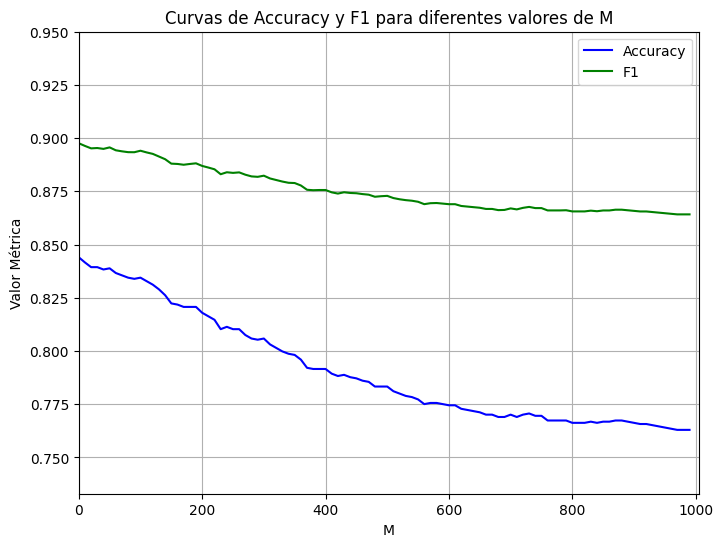

In [ ]:
funciones.plot_metricas(resultados,1000)

El valor de m que maximiza el accuracy es: 2, con un valor de: 0.8443359670632399
El valor de m que maximiza el f1 es: 2, con un valor de: 0.8978698403020292


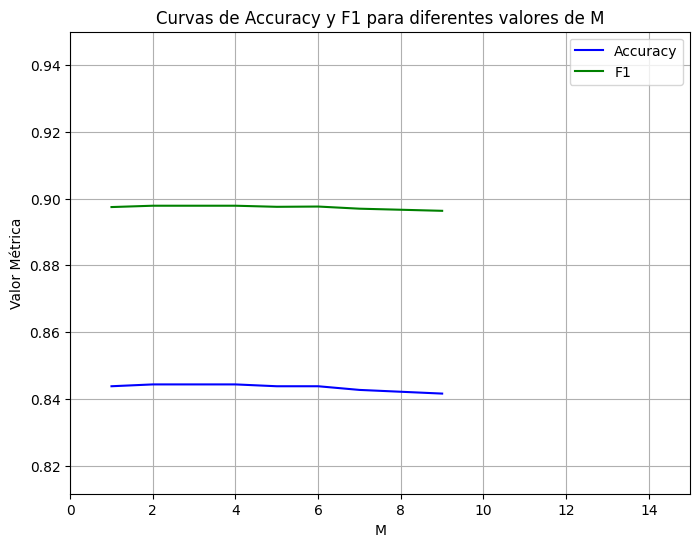

In [ ]:
m_posibles = list(range(1, 10, 1))
resultados = {}

for m in m_posibles:
    resultados[m] = funciones.validacion_cruzada(X_train, Y_train, m, atributos_a_categorizar, valores_posibles, 5)

accuracy_scores = [resultados[m][0] for m in resultados]
mejor_m_accuracy = m_posibles[np.argmax(accuracy_scores)]

f1_scores = [resultados[m][3] for m in resultados]
mejor_m_f1 = m_posibles[np.argmax(f1_scores)]

print(f"El valor de m que maximiza el accuracy es: {mejor_m_accuracy}, con un valor de: {accuracy_scores[mejor_m_accuracy]}")
print(f"El valor de m que maximiza el f1 es: {mejor_m_f1}, con un valor de: {f1_scores[mejor_m_f1]}")

funciones.plot_metricas(resultados,10)

### 3.2 Selección de atributos

A continuación, se llama a la función `seleccionar_subconjunto_a_eliminar` la cual iterará sobre todos los subconjuntos del array `potenciales_atributos_a_eliminar`, y aplicará validación cruzada sobre todos los sets de entrenamiento resultantes para obtener el subconjunto que de los mejores resultados en relación al f1.

In [ ]:
atributos_a_eliminar, accuracy_maximo, f1_maximo = funciones.seleccionar_subconjunto_a_eliminar(X_train, Y_train, mejor_m_f1, potenciales_atributos_a_dropear, valores_posibles, atributos_a_categorizar)
print(f'El subconjunto optimo para eliminar es: {atributos_a_eliminar}')
print(f'El accuracy obtenido al eliminar este subconjunto es: {accuracy_maximo}')
print(f'El f1 obtenido al eliminar este subconjunto es: {f1_maximo}')

El subconjunto optimo para eliminar es: ('wtkg', 'hemo', 'oprior', 'preanti', 'cd820')
El accuracy obtenido al eliminar este subconjunto es: 0.8470877607241244
El f1 obtenido al eliminar este subconjunto es: 0.899707567115555


### 3.3 Análisis de resultados

La siguiente tabla resume los mejores resultados obtenidos dependiendo de cuando se realizó la categorización y del valor de `max_range_split`, indicando que función de elección de atributo fue la que generó dicho valor.

<table>
  <tr>
    <th>Momento de categorización</th>
    <th>Max range split</th>
    <th>Función de elección de atributo</th>
    <th>Accuracy</th>
    <th>Precision</th>
    <th>Recall</th>
    <th>F1</th>
  </tr>
  <tr>
    <td>Durante ejecución ID3</td>
    <td>2</td>
    <td>Gain ratio</td>
    <td>0.8571</td>
    <td>0.9113</td>
    <td>0.8981</td>
    <td>0.9046</td>
  </tr>
  <tr>
    <td>Durante ejecución ID3</td>
    <td>3</td>
    <td>Gain ratio</td>
    <td>0.8755</td>
    <td>0.9300</td>
    <td>0.9029</td>
    <td>0.9163</td>
  </tr>
  <tr>
    <td>Antes de ejecución ID3</td>
    <td>2</td>
    <td>Gain ratio</td>
    <td>0.8498</td>
    <td>0.9024</td>
    <td>0.8981</td>
    <td>0.9002</td>
  </tr>
  <tr>
    <td>Antes de ejecución ID3</td>
    <td>3</td>
    <td>Ganancia de información</td>  
    <td>0.8681</td>
    <td>0.9009</td>
    <td>0.9271</td>
    <td>0.9138</td>
  </tr>
</table>


En general, no se observa un claro superior entre categorizar antes o después de ejecutar ID3, sin embargo, si nos enfocamos únicamente en el accuracy y f1, podemos identificar que los mejores resultados se obtienen utilizando:

- La función gain ratio.
- max-range-split = 3.
- Categorizando los atributos necesarios durante la ejecución del algoritmo ID3.

Si probamos estas características sobre el conjunto de testeo, obtenemos la siguiente matriz de confusión.

In [ ]:
discretizer = KBinsDiscretizer(n_bins=3, encode="ordinal", strategy='kmeans', subsample=200_000, random_state=12345)

X_train_copy = X_train.copy().drop(columns=list(atributos_a_eliminar))
X_test_copy = X_test.copy().drop(columns=list(atributos_a_eliminar))

# Se eliminan los valores necesarios de "valores_posibles" y "atributos_a_categorizar"
valores_posibles_aux = valores_posibles.copy()
atributos_a_categorizar_aux = atributos_a_categorizar.copy()
for key in atributos_a_eliminar:
    valores_posibles_aux.pop(key)
    if key in atributos_a_categorizar_aux:
        atributos_a_categorizar_aux.remove(key)

# Se calculan los puntos de corte para X_train
puntos_corte = {}
for atributo in atributos_a_categorizar_aux:
    X_train_copy[atributo] = discretizer.fit_transform(X_train_copy[[atributo]]).astype(int)
    puntos_corte[atributo] = discretizer.bin_edges_[0][1:3]
    valores_posibles_aux[atributo] = np.unique(X_train_copy[atributo])

# Se aplican los mismos puntos de corte para X_test
for atributo in atributos_a_categorizar_aux:
    X_test_copy[atributo] = np.digitize(X_test_copy[atributo], puntos_corte[atributo]).astype(int)

ModeloTest = funciones.NaiveBayesAIDS(mejor_m_f1, valores_posibles_aux)
ModeloTest.fit(X_train_copy, Y_train)
Y_pred = ModeloTest.predict(X_test_copy)

accuracy, precision, recall, f1 = funciones.get_accuracy_precision_recall_f1(Y_test, Y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

Accuracy: 0.8473520249221184
Precision: 0.907563025210084
Recall: 0.8888888888888888
F1: 0.8981288981288981


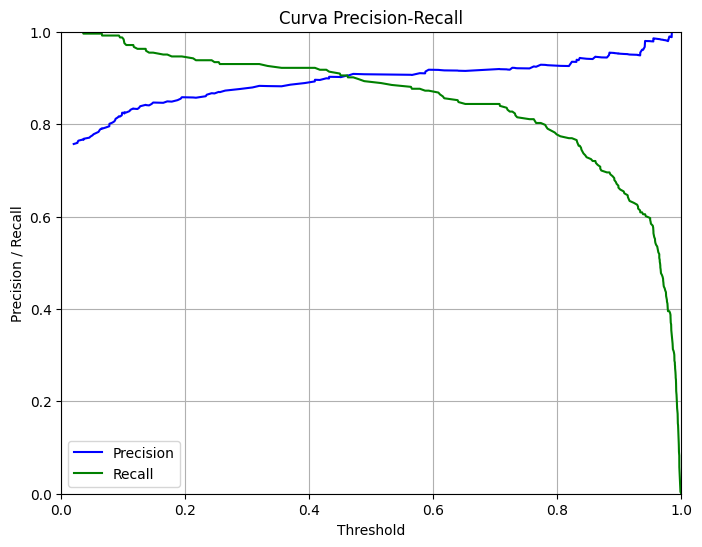

Umbral donde se da el cruce: 0.46147999822035685


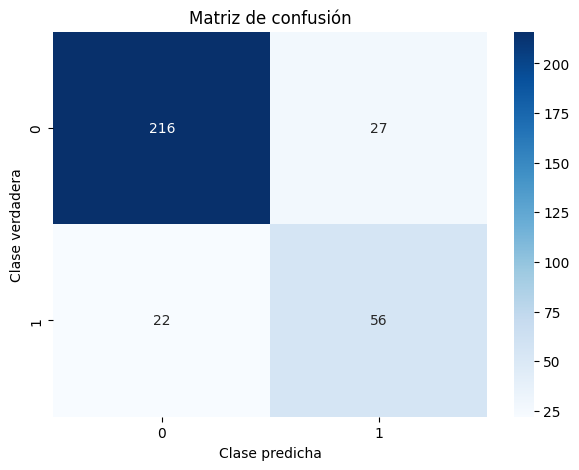

In [ ]:
funciones.curva_precision_recall(ModeloTest, X_test_copy, Y_test)
funciones.plot_confusion_matrix(Y_test, Y_pred)

## 4. Evaluación

Con la gráfica de arriba, podemos ver cómo se cumplen varias cosas:

- El predictor manual cumple con lo mínimo deseado de estar por encima de la línea base.
- El predictor manual otorga resultados competentes al nivel de la librería usada.
- RandomForest es mejor que nuestra implementación pero no por mucho.


### 4.2 Resultados de la comparación

## 5. Conclusiones

A modo de conclusión general, se logra implementar un predictor de mortalidad en pacientes con VIH utilizando árboles de decisión generados con el algoritmo ID3.

En particular, se prueban distintas configuraciones de hiper-parámetros y funciones de atributos. La combinación con mejor resultado fue utilizando la función `gain ratio`, con max_range_split de 3 y categorización _«in situ»_.

Las métricas de clasificación dieron una _accuracy_ de 0.84 y una puntuación f1 de 0.90 para la mejor configuración. Y este es competitivo con la implementación de Árboles de `scikit-learn` y, si bien el rendimiento es estrictamente inferior, es comparable con la implementación de Random Forest de la misma librería. 

Como mejoras a futuro podríamos listar:
- Explorar otros métodos de preprocesamiento de datos, como por ejemplo la selección de atributos en el dataset.
- Probar métodos más complejos como Random Forest.
- Aplicar técnicas para reducir el overfitting en caso de haberlo, como puede ser early stopping.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c37fbc8c-fee1-4291-8075-be0e33896680' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>